## Lecture 4: Model Improvements and  Pipelines

In this lecture we are going to build upon the knowledge of last week(s). We will combine data preprocessing steps with ML models and crete data pipelines. In addition, a few tips of model improvements (class imbalance) will be discussed.

This week you will learn:
* Something about Random-forest and deep learning.
* How to combine data-preprocessing and modelling in a data pipeline.
* How to use different models on a given, practical problem.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [3]:
from generate_dataset import generate_dataset

## Data Pipeline

To illustrate the use of data pipelines, we are going to generate data using a function that I created (see generate_dataset.py). The task will be a classification task and will contain both numerical and categorical features. Unlike last we week, we will use the sklearn function make_classification to generate our data.

In [4]:
from secrets import choice


X_train, X_test, y_train, y_test = generate_dataset()

For our data pipeline, we need to know which features are categorical or numerical. Both types of variables require different steps in the preprocessing pipeline. Categorical features need to be numerically encoded (e.g: 1h-encoding). Numerical features need (in many cases) to be standardized (see lecture 2).

In [5]:
categorical_cols = [column for column in X_train.columns if 'categorical' in column]
numerical_cols = [column for column in X_train.columns if 'numerical' in column]

We will now create a pipeline using ColumnTransformer and Pipeline from sklearn.

In [6]:
# create ColumnTransformer, and pass the column names to transform in each step

def make_pipeline(categorical_cols=[], numerical_cols=[], classifier=LogisticRegression()):
    preprocessor = ColumnTransformer(
        [
            ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
            ('scale', StandardScaler(), numerical_cols)
        ]
    )

    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )

    return clf


Now that we have defined our pipeline, let's see how different models will perform on our generated data. We define the models that we want to test in the list below.

In [7]:
models_to_run = [
    LogisticRegression(multi_class='multinomial'),
    RandomForestClassifier(max_depth=2),
    RandomForestClassifier(max_depth=5),
    RandomForestClassifier(max_depth=10),
    RandomForestClassifier(max_depth=20),
    RandomForestClassifier(max_depth=80),
    MLPClassifier(hidden_layer_sizes=2),
    MLPClassifier(hidden_layer_sizes=6),
    MLPClassifier(hidden_layer_sizes=10),
    MLPClassifier(hidden_layer_sizes=20),
    MLPClassifier(hidden_layer_sizes=40)
]
    

The standard classification metric to evaluate models in sklearn pipelines is the Accuracy. The Accuracy is the number of correct predictions out of all the datapoints. This metric works ok in generic situations, but might not be the best in cases where the distribution of the target, y, is not even. This situation is normally referred to as **unbalanced**.

We will quickly assess our target distribution to see if it is balancef or unbalanced before we continue.

([<matplotlib.patches.Wedge at 0x1691979a0>,
 [Text(0.5737659537757365, 0.9385055302382718, '0'),
  Text(-1.0978293989430645, 0.06906960848527927, '1'),
  Text(0.5137044751207129, -0.9726806835960881, '2')])

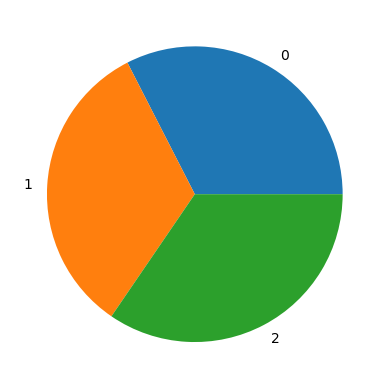

In [8]:
plt.pie(np.bincount(y_train) / len(y_train), labels=np.unique(y_train))

The distribution is approximately even, so the Accuracy will suffice. We will now run the models on our data, store the clasification results (the Accuracy!) and show them using a pandas dataframe.

In [9]:
results = {}
for model in models_to_run:

    # create instance of the class, feed the model to be tested
    clf = make_pipeline(categorical_cols, numerical_cols, model)
    clf.fit(X_train, y_train)

    # store results in a dictionary 
    results[str(model)] = clf.score(X_test, y_test)
pd.DataFrame.from_dict(results, orient='index', columns=['score'])

/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

,score
LogisticRegression(multi_class='multinomial'),0.532
RandomForestClassifier(max_depth=2),0.708
RandomForestClassifier(max_depth=5),0.732
RandomForestClassifier(max_depth=10),0.748
RandomForestClassifier(max_depth=20),0.724
RandomForestClassifier(max_depth=80),0.740
MLPClassifier(hidden_layer_sizes=2),0.536
MLPClassifier(hidden_layer_sizes=6),0.680
MLPClassifier(hidden_layer_sizes=10),0.716
MLPClassifier(hidden_layer_sizes=20),0.744


There are big differences between the performances, but the random forest and the neural network seem to be the big winners. Clearly, there is something to gain from upgrading from the simple logstic regression to RF or NN. So what exactly are the the weak/strong points of these algorithm and how do we know when to use which one?



### LOGISTIC REGRESSION
**Advantages**: interpretable results and should be used in cases where you want to understand relationships.

**Disadvantages**: often not able to capture complex/relationships and doesnt work well out of the box if non-linearities are present.

### RANDOM FOREST
**Advantages**: works very well out of the box. Is resilient against overfitting and is able to capture complex (non-linear) relationships. Almost no data-preprocessing is needed!

**Disadvantages**: there are many hyperparamers to tune, not as interpretable as logistic regression.

### Neural Network
**Advantages**: can theoretically model any relation. Can lead to very high results, IF tuned properly. 

**Disadvantages**: very easy to overfit, designing a model can take a long time, almost no interpretability. 

## WINE DATASET

So, let's see how well our pipeline will perform on some real-world examples. Our first stop is the famous 'wine' dataset, where we ought to predict the quality of wines given several features.

In [10]:
wine = pd.read_csv('../../static/data/winequality-red.csv')

In [11]:
y_wine = wine['quality']
X_wine = wine.drop(['quality'], axis=1)

This dataset is actually a regression problem, but we will change it into a classification problem by grouping the target. We will create two groups: 'medium' with all rating up to and including 6, and 'excellent' containg all ratings from 7.

In [12]:
# Create Classification version of target variable
y_wine = pd.Series([1 if x >= 7 else 0 for x in y_wine])

In [13]:
y_wine = y_wine.replace({0: 'medium', 1: 'excellent'})

So what do our features look like?

In [14]:
X_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


Do we have any categorical feature hiding in our dataset that we would want to one-hot-encode with our pipeline?

Remember that a categorical feature often has a low number of unique values.

In [15]:
X_wine.nunique()

fixed acidity            96
volatile acidity        143
citric acid              80
residual sugar           91
chlorides               153
free sulfur dioxide      60
total sulfur dioxide    144
density                 436
pH                       89
sulphates                96
alcohol                  65
dtype: int64

Thw output above shows the number of unique values per feature. If the number of unique values is low, it could be an indication that it is better to treat the variable as `categorical` (make them a string).

The dataset has a total of 1600 rows (or observations), so in this case I would say that it is ok to treat all the variables as numerical.

For class balance we have to plot the distribution of the target again.

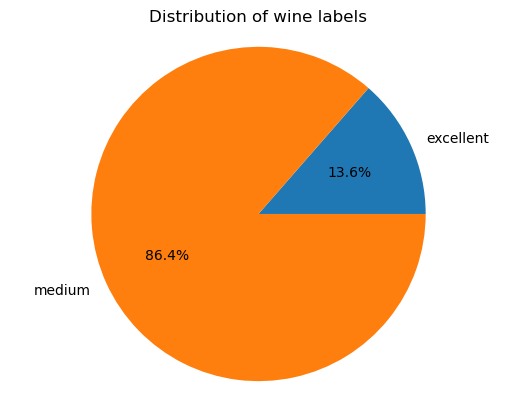

In [16]:
labels_wine, counts_wine = np.unique(y_wine, return_counts=True)
plt.pie(counts_wine / len(y_wine), labels=labels_wine, autopct='%1.1f%%')
plt.title('Distribution of wine labels')
plt.axis('equal')
plt.show()


The distribution of the labels is a off. It means that we can get 86% accuracy by always predicting 'medium'. Therefor we need a metric that somehow corrects for this. We find our corrected metric in someone called the 'F1 score'. We will also try to 'fix' the class imbalance by adding a parameter to our pipeline.

In [17]:
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine, test_size=.50, random_state=15)

We dont have categorical features in our dataset, so we dont need to process them. We standardize all of our features! 

In [18]:
categorical_cols = []
numerical_cols = X_train_wine.columns

In [19]:
from sklearn.metrics import f1_score

results = {}
for model in models_to_run:

    # create instance of the class, feed the model to be tested
    clf = make_pipeline(categorical_cols, numerical_cols, model)
    clf.fit(X_train_wine, y_train_wine)

    # store results in a dictionary 
    results[str(model)] = f1_score(y_test_wine, clf.predict(X_test_wine), average='weighted')
pd.DataFrame.from_dict(results, orient='index', columns=['score'])


/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

,score
LogisticRegression(multi_class='multinomial'),0.868228
RandomForestClassifier(max_depth=2),0.816110
RandomForestClassifier(max_depth=5),0.884896
RandomForestClassifier(max_depth=10),0.904790
RandomForestClassifier(max_depth=20),0.897227
RandomForestClassifier(max_depth=80),0.901566
MLPClassifier(hidden_layer_sizes=2),0.832854
MLPClassifier(hidden_layer_sizes=6),0.864354
MLPClassifier(hidden_layer_sizes=10),0.853105
MLPClassifier(hidden_layer_sizes=20),0.868115


An interesting observation is that the Neural Network does not seem to do much better than the Random Forest. Ofcourse, this might be different with proper hyperparameter tuning (see next week!), but something else must be mentioned. On tabular data (data that fit into an excel spreadsheet), Neural Networks might not be the best choice. A Random Forest, on the other hand, tends to have a good performance on tabular data.

Our minority class (excellent wines!) only has an occurence of 13%. Luckily there is a trick in sklearn's random forest algorithm, a single parameter that we can use in order to correct for this. This parameter is called `class_weight` and we want to set it to `balanced` in order to tackle class imbalance.

 It to our pipeline we do this as follows:

In [20]:
# create ColumnTransformer, and pass the column names to transform in each step

def make_pipeline(categorical_cols=[], numerical_cols=[], classifier=LogisticRegression()):

    if isinstance(classifier, RandomForestClassifier):
        setattr(classifier, 'class_weight', 'balanced')

    preprocessor = ColumnTransformer(
        [
            ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
            ('scale', StandardScaler(), numerical_cols)
        ]
    )

    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )

    return clf


In [21]:
from sklearn.metrics import f1_score

results = {}
for model in models_to_run:

    # create instance of the class, feed the model to be tested
    clf = make_pipeline(categorical_cols, numerical_cols, model)
    clf.fit(X_train_wine, y_train_wine)

    # store results in a dictionary 
    results[str(model)] = f1_score(y_test_wine, clf.predict(X_test_wine), average='weighted')
pd.DataFrame.from_dict(results, orient='index', columns=['score'])


/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

,score
LogisticRegression(multi_class='multinomial'),0.868228
"RandomForestClassifier(class_weight='balanced', max_depth=2)",0.826445
"RandomForestClassifier(class_weight='balanced', max_depth=5)",0.868879
"RandomForestClassifier(class_weight='balanced', max_depth=10)",0.905614
"RandomForestClassifier(class_weight='balanced', max_depth=20)",0.893909
"RandomForestClassifier(class_weight='balanced', max_depth=80)",0.900417
MLPClassifier(hidden_layer_sizes=2),0.832443
MLPClassifier(hidden_layer_sizes=6),0.859364
MLPClassifier(hidden_layer_sizes=10),0.874002
MLPClassifier(hidden_layer_sizes=20),0.873319


Unfortunately the parameter did not change our model for the better. This can ofcourse always happen in Machine Learning, which is sometimes more of an art than a science. Several other methods to combat class imbalance could be checked for (oversampling, smote...), but an increase in performance is never guaruanteed. 

## IN PRACTICE: MNIST DATASET

We will turn to a second problem: the classification of handwritten digits. This is a computer vision task, and we know that Logistic Regression and Random Forest are ill-equipped for this task. Instead, we will add a convolutional neural network to our pipeline.

In [22]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import (
    Conv2D, 
    Dense, 
    Dropout, 
    Flatten, 
    MaxPool2D
)

In [23]:
from sklearn.datasets import load_digits

In [24]:
(X_digits_train, y_digits_train), (X_digits_test, y_digits_test) = load_data()

So what does our data look like?

In [25]:
X_digits_train[:, :, :]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [26]:
X_digits_train.shape

(60000, 28, 28)

So it is important to understand that this dataset is fundamentally different than the datasets that we have seen so far. Before we were seeing N * P datasets, where N is the number of data points and P is the number of features. Our current dataset is N * H * W. N is still the number of data points, but H refers to the height of the image and W to its width. Every cell in this array has a number attached to it to determine its colour (0 = black).

Let's see if we can plot some images.

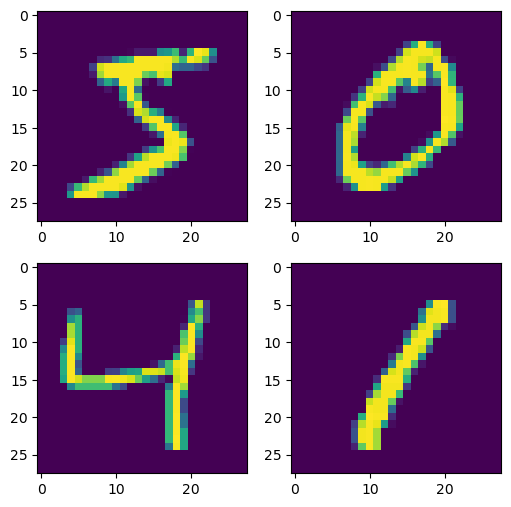

In [27]:
plt.figure(figsize=(6,6)) # specifying the overall grid size

for i in range(4):
    plt.subplot(2,2,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(X_digits_train[i])

plt.show()

So the task is clear. We have these handwritten numbers and we will see if we can classify them correctly. 

The models that we have seen so far, dont do good job on data like this. They do well on somewhat independent features, not on images with strong local correlations. We will, however, compare their (LR, RF..) performance to our new convolutional neural network.

To create our conv. neural network, we will turn to a library called `tensorflow/Keras`. For your understanding: Tensorflow is an ML/AI library that is optimized for mathematical operations. Keras is a library that runs on top of Tensorflow and does Deep Learning/Neural Networks.  This library allows us to completely customize our neural network to our needs. A proper introduction to Tensorflow is outside the scope of this course, but in practice we stack layers after each other. The final layer returns 10 values, with a probability for each possible output (the number 0 up to 10).

In [28]:
# defining the model
inp_shape = X_digits_train.shape[1:]

def create_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=inp_shape + (1,)))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(48, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

We wrap our model in KerasClassifier and then add it to our models_to_run.

In [29]:
nn_clasifier = KerasClassifier(build_fn=create_model, verbose=0)

/var/folders/zq/9lh8_0ds0611mg3hwzksgm0r0000gn/T/ipykernel_32973/803054884.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_clasifier = KerasClassifier(build_fn=create_model, verbose=0)


In [30]:
models_to_run = [
    LogisticRegression(multi_class='multinomial'),
    RandomForestClassifier(max_depth=20),
    MLPClassifier(hidden_layer_sizes=20),
    nn_clasifier
]

Our convolutional network is able to handle images, but the other models cannot. These models expect a N * P input (two dimensions) and not a N * H * W input (three dimensions). For those models we will average over the third dimension to get to our N * P format. We will, ofcourse, lose information in the process.

In [31]:
# create ColumnTransformer, and pass the column names to transform in each step
from sklearn.preprocessing import FunctionTransformer

def mean_over_second_image_dimension(img):
    return np.mean(img, axis=2)

transformer = FunctionTransformer(mean_over_second_image_dimension)


def make_pipeline_mnist(classifier=LogisticRegression()):

    clf = Pipeline(
        steps=[
            ('classifier', classifier)
        ]
    )

    # check if instance is KerasClassifier, if not, add first steo to reduce
    # the dimensions
    if not isinstance(classifier, KerasClassifier):
        clf.steps.insert(0, ['estimator', transformer]) #insert as first step


    return clf


Lets run the pipelines again and store our results

In [32]:
results = {}
for model in models_to_run:
    # create instance of the class, feed the model to be tested
    clf = make_pipeline_mnist(model)
    clf.fit(X_digits_train, y_digits_train)

    # store results in a dictionary 
    results[str(model)] = clf.score(X_digits_test, y_digits_test)
pd.DataFrame.from_dict(results, orient='index', columns=['score'])

As expected our convolutional network does a bitter job than the other algorithms! But, there are some tricks to upgrade their performances... see exercise!

## Exercise / bonus tutorial
Our previous method to reduce the dimensionality of the mnist inputs in order to prepare them for a Random Forest, is probably not the best. Instead of it, we will turn to a different approach. 

In fact, we want to perform Dimensionality Reduction. This could also be achieved by the unsupervised ML-method of Principal Component Analysis (PCA). In this exercise, we will use this method to prepare our image data for a Random Forest.

1. load PCA from sklearn

In [ ]:
from sklearn.decomposition import PCA

2. Replace the mean_over_second_image_dimension function by a reshape_image function. It should use np.reshape() and replace the 28 x 28 format by the 728 x 1 format.

In [ ]:
# create ColumnTransformer, and pass the column names to transform in each step
from sklearn.preprocessing import FunctionTransformer

# def mean_over_second_image_dimension(img):
#     return np.mean(img, axis=2)

def reshape_image(img):
    
    # Your code here


IndentationError: expected an indented block (4007972144.py, line 9)

3. Add both the transformation step from the previous cell, and PCA to the pipeline below. For PCA, use the parameter n_components=20.

In [ ]:
def make_pipeline_mnist(classifier=LogisticRegression()):

    clf = Pipeline(
        steps=[
            ('classifier', classifier)
        ]
    )

    # check if instance is KerasClassifier, if not, add first steo to reduce
    # the dimensions
    
    if not isinstance(classifier, KerasClassifier):
        
        # your code here


    return clf

4. Run the new pipeline on all the previous models 

5. What is the upgrade in performance ? ;-)